In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Draw

ModuleNotFoundError: No module named 'rdkit'

## Tissue Types

In [60]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")
drm.head(3)

Finished reading drug response matrix: (137835, 9)


,DATASET,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,SANGER_MODEL_ID,AUC,RMSE,Z_SCORE,LN_IC50
333161,GDSC2,PFSK-1,Camptothecin,1003,SIDM01132,0.930105,0.088999,0.432482,-1.462148
333162,GDSC2,A673,Camptothecin,1003,SIDM00848,0.614932,0.111423,-1.420322,-4.869447
333163,GDSC2,ES5,Camptothecin,1003,SIDM00263,0.790953,0.142754,-0.599894,-3.360684


In [67]:
path_to_cl_details = '../../data/raw/Cell_Lines_Details.xlsx'

cl_details = pd.read_excel(path_to_cl_details, header=0)
cl_details.rename(columns={
    'Sample Name': 'CELL_LINE_NAME',
    'GDSC\nTissue descriptor 1': 'GDSC_Tissue_Descriptor_1',
    'GDSC\nTissue\ndescriptor 2': 'GDSC_Tissue_Descriptor_2'
}, inplace=True)
print("Cell line details: ", cl_details.shape)
cl_details.head(3)

Cell line details:  (1002, 13)


/home/ec2-user/anaconda3/envs/gnn2803/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,CELL_LINE_NAME,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC_Tissue_Descriptor_1,GDSC_Tissue_Descriptor_2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [70]:
drm_with_tissues = pd.merge(drm[['CELL_LINE_NAME', 'DRUG_NAME', 'DRUG_ID']], 
                            cl_details[['CELL_LINE_NAME', 'GDSC_Tissue_Descriptor_1', 'GDSC_Tissue_Descriptor_2']], 
                            on='CELL_LINE_NAME', how='left')
print(drm_with_tissues.shape)
print(f"Uniqe tissue descriptors 1: {drm_with_tissues['GDSC_Tissue_Descriptor_1'].nunique()}")
print(f"Uniqe tissue descriptors 2: {drm_with_tissues['GDSC_Tissue_Descriptor_2'].nunique()}")
drm_with_tissues.head(3)

(137835, 5)
Uniqe tissue descriptors 1: 19
Uniqe tissue descriptors 2: 54


,CELL_LINE_NAME,DRUG_NAME,DRUG_ID,GDSC_Tissue_Descriptor_1,GDSC_Tissue_Descriptor_2
0,PFSK-1,Camptothecin,1003,nervous_system,medulloblastoma
1,A673,Camptothecin,1003,soft_tissue,rhabdomyosarcoma
2,ES5,Camptothecin,1003,bone,ewings_sarcoma


In [71]:
drm_with_tissues['GDSC_Tissue_Descriptor_1'].unique().tolist()

['nervous_system',
 'soft_tissue',
 'bone',
 'skin',
 nan,
 'urogenital_system',
 'lung_NSCLC',
 'lung_SCLC',
 'neuroblastoma',
 'myeloma',
 'pancreas',
 'aero_dig_tract',
 'breast',
 'kidney',
 'leukemia',
 'large_intestine',
 'lymphoma',
 'thyroid',
 'digestive_system',
 'lung']

Text(0.5, 1.0, 'Tissue Descriptors in GDSC2')

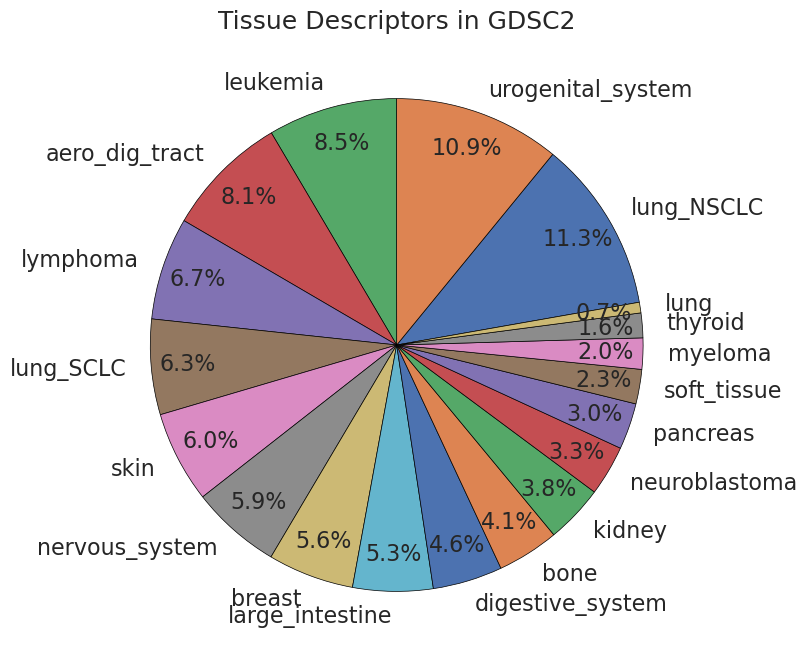

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract the values and their counts from the column
tissue_counts = drm_with_tissues['GDSC_Tissue_Descriptor_1'].value_counts()

# Extract the unique tissue descriptors and their counts
tissue_labels = tissue_counts.index
tissue_values = tissue_counts.values

# Create a pie plot with percentages outside the pie using Seaborn
fig, ax = plt.subplots(figsize=(10, 10))

ax = plt.pie(tissue_values, 
             labels=tissue_labels, 
             autopct='%1.1f%%', 
             startangle=10, 
             pctdistance=0.85,
             textprops={'fontsize': 16},
             wedgeprops={'edgecolor': 'black', 'linewidth': 0.5})
plt.title("Tissue Descriptors in GDSC2", fontsize=18)

fig.savefig(f'outputs/gdsc2_tissue_descriptors.png', dpi=300)

## Drugs

In [5]:
path_to_drm = '../../data/processed/gdsc2/gdsc2_drm.pkl'
path_to_simles_graphs = '../../data/processed/gdsc2/gdsc2_smiles_graphs.pkl'
path_to_fps = '../../data/processed/gdsc2/gdsc2_smiles_dict.pkl'

with open(path_to_drm, 'rb') as f: 
    drm = pickle.load(f)
    print(f"Finished reading drug response matrix: {drm.shape}")

# Read drug smiles graphs.
with open(path_to_simles_graphs, 'rb') as f: 
    drug_graphs = pickle.load(f)
    print(f"Finished reading drug SMILES graphs: {drug_graphs[1003]}")
    
with open(path_to_fps, 'rb') as f:
    fingerprints_dict = pickle.load(f)   

Finished reading drug response matrix: (137835, 9)


/home/ec2-user/anaconda3/envs/gnn2803/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finished reading drug SMILES graphs: Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


Drug name  : Temozolomide
Drug id    : 1375
Drug graph : Data(x=[14, 9], edge_index=[2, 30], edge_attr=[30, 3], smiles='Cn1c(=O)n2cnc(C(=O)N)c2nn1')
Fingerprint: [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


(-0.5, 799.5, 799.5, -0.5)

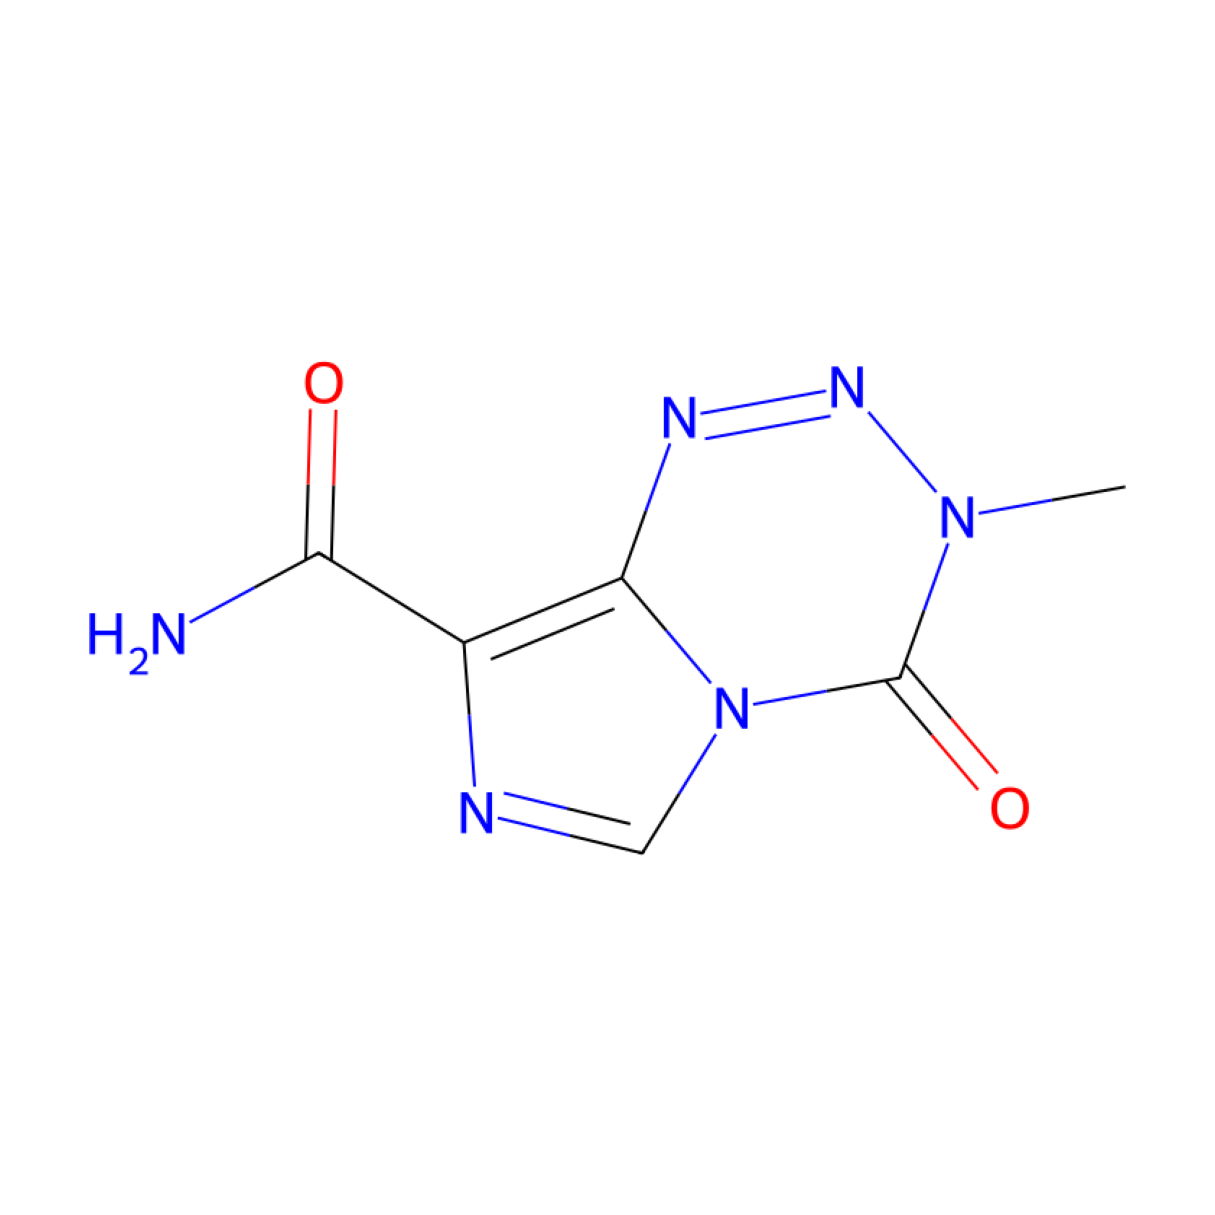

In [57]:
drug_name = 'Temozolomide'
drug_id = drm[drm['DRUG_NAME']==drug_name]['DRUG_ID'].iloc[0]
drug_graph = drug_graphs.get(drug_id)
print(f"Drug name  : {drug_name}")
print(f"Drug id    : {drug_id}")
print(f"Drug graph : {drug_graph}")
print(f"Fingerprint: {fingerprints_dict.get(drug_id)}")

mol = Chem.MolFromSmiles(drug_graph.smiles);
img = Draw.MolToImage(mol, size=(800, 800), fitImage=True)

plt.figure(figsize=(5, 5), dpi=300)
plt.imshow(img)
plt.axis('off')

plt.savefig(f'outputs/molecule_plot_{drug_name}.png', dpi=300)
plt.savefig(f'outputs/molecule_plot_{drug_name}_transparent.png', dpi=300, transparent=True)

Drug name  : Camptothecin
Drug id    : 1003
Fingerprint: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Drug graph : Data(x=[26, 9], edge_index=[2, 60], edge_attr=[60, 3], smiles='CC[C@@]1(c2cc3c4c(cc5ccccc5n4)Cn3c(=O)c2COC1=O)O')


(-0.5, 799.5, 799.5, -0.5)

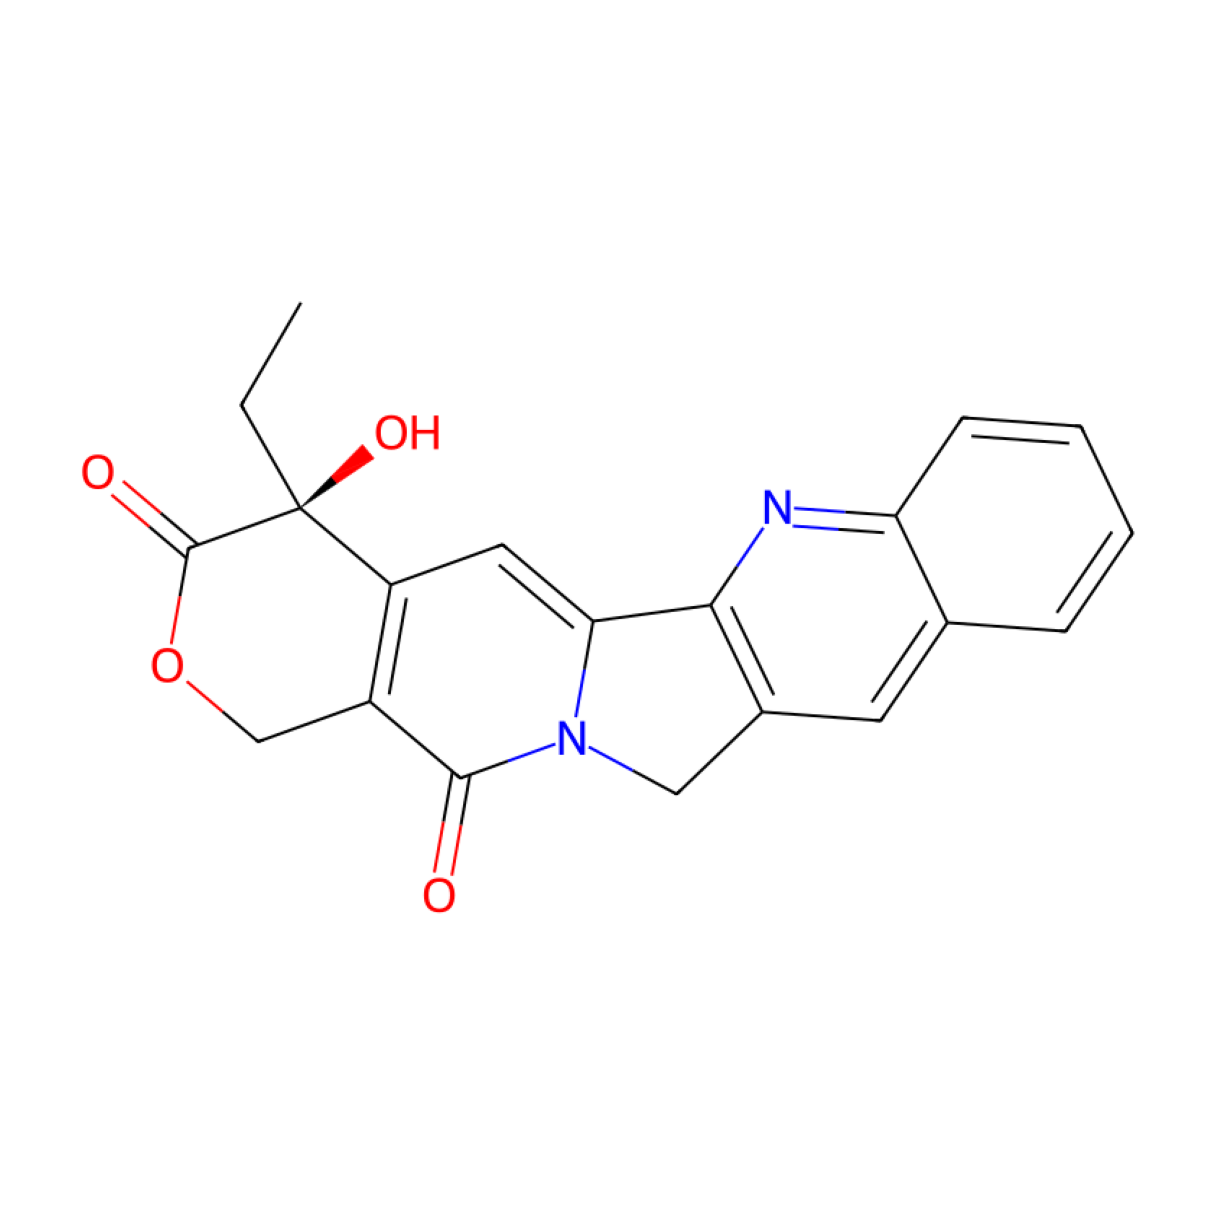

In [58]:
drug_name = 'Camptothecin'
drug_id = drm[drm['DRUG_NAME']==drug_name]['DRUG_ID'].iloc[0]
drug_graph = drug_graphs.get(drug_id)
print(f"Drug name  : {drug_name}")
print(f"Drug id    : {drug_id}")
print(f"Fingerprint: {fingerprints_dict.get(drug_id)}")
print(f"Drug graph : {drug_graph}")

mol = Chem.MolFromSmiles(drug_graph.smiles);
img = Draw.MolToImage(mol, size=(800, 800), fitImage=True)

plt.figure(figsize=(5, 5), dpi=300)
plt.imshow(img)
plt.axis('off')

plt.savefig(f'outputs/molecule_plot_{drug_name}.png', dpi=300)
plt.savefig(f'outputs/molecule_plot_{drug_name}_transparent.png', dpi=300, transparent=True)